In [1]:
class Particle:
    def __init__(self, particleText, METPhi):
        
        #Get our list of quantities for the particle
        particleInfo = particleText.split(",")
        
        #Define our particle quantities
        self.obj = particleInfo[0]
        self.E = float(particleInfo[1])
        self.pt = float(particleInfo[2])
        self.eta = float(particleInfo[3])
        self.phi = float(particleInfo[4])
        self.deltaPhi = abs(self.phi-METPhi)
        
    def __str__(self):
        return "(obj: " + self.obj + ", E: " + str(self.E) + ", pt: " + str(self.pt) + ", eta: " + str(self.eta) + ", phi: " +str(self.phi) + ")"
    
    def getQuantity(self, quantityType):
        
        if quantityType == "E":
            return self.E
        
        elif quantityType == "pt":
            return self.pt
        
        elif quantityType == "eta":
            return self.eta
        
        elif quantityType == "phi":
            return self.phi
        
        elif quantityType == "deltaPhi":
            return self.deltaPhi
        
        else:
            print("Error: Invalid quantity type")
            return 0.0
        
    __repr__=__str__

In [57]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import tabulate
import math
from IPython.display import HTML, display

In [3]:
def makeMatrixValues(ptList, pxSquaredList, pySquaredList, pxpyList):
    
    #Create the values to put in our momentum matrix
    ptSum = sum(ptList)
    pxSquaredSum = sum(pxSquaredList)/ptSum
    pySquaredSum = sum(pySquaredList)/ptSum
    pxpySum = sum(pxpyList)/ptSum
    
    return pxSquaredSum, pySquaredSum, pxpySum

In [4]:
def createMatrix(ptList, pxSquaredList, pySquaredList, pxpyList):
    
    #Create the values to put in our momentum matrix
    pxSquaredSum, pySquaredSum, pxpySum = makeMatrixValues(ptList, pxSquaredList, pySquaredList, pxpyList)
    
    #Create the momentum matrix
    pMatrix = [[pxSquaredSum, pxpySum], [pxpySum, pySquaredSum]]
    
    return pMatrix

In [5]:
def getEigenValues(ptList, pxSquaredList, pySquaredList, pxpyList):
    
    #Create the momentum matrix
    pMatrix = createMatrix(ptList, pxSquaredList, pySquaredList, pxpyList)
    
    #Get the eigenvalues of our momentum matrix. We will use these eigenvalues to calculate transverse sphericity
    eigenValues, eigenVectors = np.linalg.eig(pMatrix)
    
    return eigenValues

In [6]:
def computeSTFromEigenValues(eigenValues):
    
    #Define the eigenvalues needed to calculate transverse sphericity
    eigenValue1 = max(eigenValues)
    eigenValue2 = min(eigenValues)
    
    ST = 2.0*eigenValue2/(eigenValue1+eigenValue2)
    
    return ST

In [7]:
def getPValues(particle):
    
    #Get the particle quantities needed to get these values
    pt = particle.pt
    phi = particle.phi
    
    #Get the x and y components of momentum
    px = pt*np.cos(phi)
    py = pt*np.sin(phi)
    
    #These are values needed to create the momentum matrix to calcule transverse sphericity
    pxSquared = px**2/pt
    pySquared = py**2/pt
    pxpy = px*py/pt
    
    return pt, pxSquared, pySquared, pxpy

In [8]:
def checkJets(obj):
    return obj in ["j", "b"]

def checkLeptons(obj):
    return obj in ["e-", "e+", "m-", "m+"]

def checkPhotons(obj):
    return obj=="g"

In [9]:
def calculateST(ptList, pxSquaredList, pySquaredList, pxpyList):
    
    #Make the matrix and get the eigenvalues needed to calculate ST
    eigenValues = getEigenValues(ptList, pxSquaredList, pySquaredList, pxpyList)
    
    ST = computeSTFromEigenValues(eigenValues)
    
    return ST

In [10]:
def makeFeatures(MET, METPhi, eventInfo):
    
    #total number of datapoints in the line
    length = len(eventInfo)
    
    # define quantitity lists needed for calculating transverse sphericity
    particleList = []
    pxSquaredList = []
    pySquaredList = []
    pxpyList = []
    ptList = []
    
    #Define the absolute sum of transverse momentum to calculate Meff
    absolutePtSum = 0.0
    
    #Define the count for the various particle types
    jets = 0
    leptons = 0
    photons = 0
    
    #Increment over all of the particles in the line
    for i in range(5, length):
        
        #Get the text for the particle
        particleText = eventInfo[i]
        
        #Make sure that it is actually information for the particle
        if particleText != "" and particleText != "\n":
            
            particle = Particle(particleText, METPhi)
            
            #get the type of particle
            obj = particle.obj
            
            #count the particles of each type
            if checkJets(obj):
                jets += 1
                
            elif checkLeptons(obj):
                leptons += 1
                
            elif checkPhotons(obj):
                photons += 1
            
            #Get the momentum-derived values needed to calulate features
            pt, pxSquared, pySquared, pxpy = getPValues(particle)
            
            pxSquaredList.append(pxSquared)
            pySquaredList.append(pySquared)
            pxpyList.append(pxpy)
            ptList.append(pt)
            
            absolutePtSum += abs(pt)
            
            particleList.append(particle)
    
    ST = calculateST(ptList, pxSquaredList, pySquaredList, pxpyList)
    
    Meff = MET + absolutePtSum
    
    return particleList, jets, leptons, photons, Meff, ST

In [11]:
def makeEvent(line):
    
    eventInfo = line.split(";")
    
    eventID = eventInfo[0]
    processID = eventInfo[1]
    eventWeight = float(eventInfo[2])
    MET = float(eventInfo[3])
    METPhi = float(eventInfo[4])
    
    particleList, jets, leptons, photons, Meff, ST = makeFeatures(MET, METPhi, eventInfo)
    
    crossSection = 1.0
    
    event = {
        "eventID" : eventID,
        "processID" : processID,
        "eventWeight" : eventWeight,
        "MET" : MET,
        "METPhi" : METPhi,
        "particleList" : particleList,
        "jets" : jets,
        "leptons" : leptons,
        "photons" : photons,
        "crossSection" : crossSection,
        "Meff" : Meff,
        "ST" : ST
    }
    
    return event

In [12]:
def calculateSignalCrossSection(event, length):
    
    eventWeight = event["eventWeight"]
    
    crossSection = eventWeight*length
    
    return crossSection

In [13]:
def calculateBackgroundCrossSection(length, luminosity):
    
    crossSection = length/luminosity
    
    return crossSection

In [14]:
def calculateCrossSection(event, length, luminosity, signal):
    if signal:
        return calculateSignalCrossSection(event, length)
    else:
        return calculateBackgroundCrossSection(length, luminosity)

In [15]:
def makeDataList(filePath, signal, luminosity = 1.0):
    
    file = open(filePath, "r")
    
    dataList = []
    
    for line in file:
        
        event = makeEvent(line)
        
        dataList.append(event)

    file.close()
    
    length = float(len(dataList))
    
    for event in dataList:
        
        event["crossSection"] = calculateCrossSection(event, length, luminosity, signal)
    
    
    return dataList

In [16]:
def countEventQuantity(dataList, quantityType):
    
    quantityList = []
    crossSectionList = []
    
    for event in dataList:
        
        quantity = event[quantityType]
        crossSection = event["crossSection"]
        
        quantityList.append(quantity)
        crossSectionList.append(crossSection)
    
    return quantityList, crossSectionList

In [17]:
def countParticleQuantity(dataList, quantityType):
     
    quantityList = []
    crossSectionList = []
    
    for event in dataList:
        
        particleList = event["particleList"]
        crossSection = event["crossSection"]
        
        for particle in particleList:
            
            quantity = particle.getQuantity(quantityType)
            
            quantityList.append(quantity)
            crossSectionList.append(crossSection)
    
    return quantityList, crossSectionList

In [18]:
def countQuantity(dataList, quantityType):
    
    if quantityType in ["MET", "METPhi", "jets", "leptons", "photons", "Meff", "ST"]:
        return countEventQuantity(dataList, quantityType)
    
    elif quantityType in ["E", "pt", "eta", "phi", "deltaPhi"]:
        return countParticleQuantity(dataList, quantityType)
    else:
        print("Error: Invalid quantity type")
        return []

In [19]:
def normalize(hist, bin_edges, crossSections, luminosity):
    
    bin_size = bin_edges[1] - bin_edges[0]
    integral = sum(hist) * bin_size
    num_expected = crossSections[0]*luminosity
    normalizedCount = (num_expected/integral) * hist
    
    return normalizedCount
    

In [20]:
def normalizeArea(hist, bin_edges):
    
    bin_size = bin_edges[1] - bin_edges[0]
    integral = sum(hist) * bin_size
    normalizedCount = (1.0/integral) * hist
    
    return normalizedCount

In [21]:
def getDefaults(kwargs, keys):
    
    if "numBins" in keys:
        numBins = kwargs["numBins"]
    else:
        numBins = 100
        
    if "luminosity" in keys:
        luminosity = kwargs["luminosity"]
    else:
        luminosity = 10000000
    
    return numBins, luminosity

In [22]:
def formatPlot(kwargs, keys):
    
    if "legend" in kwargs and not kwargs["legend"]:
        pass
    else:
        plt.legend()
    
    if "title" in keys:
        plt.title(kwargs["title"])
    if "xlabel" in keys:
        plt.xlabel(kwargs["xlabel"])
    if "ylabel" in keys:
        plt.ylabel(kwargs["ylabel"])

In [23]:
def compareData(data, quantityType, **kwargs):
    
    keys = kwargs.keys()
    
    numBins, luminosity = getDefaults(kwargs, keys)
    
    for label,dataSet in data.items():
        count, crossSections = countQuantity(dataSet, quantityType)
        hist, bin_edges = np.histogram(count, bins=numBins)
        normalizedCount = normalize(hist, bin_edges, crossSections, luminosity)
        plt.step(bin_edges[1:], normalizedCount, label=label)
        
    formatPlot(kwargs, keys)
    
    plt.show()
    plt.close()


In [24]:
def computeTPR(signal, numBins):
    TPR, bins, dummy = plt.hist(signal, bins = numBins, histtype = "step", cumulative = -1, density = True)
    plt.close()
    return TPR, bins

def computeFPR(background, numBins):
    FPR, bins, dummy = plt.hist(background, bins = numBins, histtype = "step", cumulative = -1, density = True)
    plt.close()
    return FPR, bins

In [25]:
def getTPRFPR(data, quantityType, numBins):
    
    signalData = data["Signal"]
    backgroundData = data["Background"]
    
    signalCount, signalCrossSections = countQuantity(signalData, quantityType)
    backgroundCount, backgroundCrossSections = countQuantity(backgroundData, quantityType)
    
    TPR, TPRbins = computeTPR(signalCount, numBins)
    FPR, FPRbins = computeFPR(backgroundCount, numBins)
    
    return TPR, FPR, TPRbins, FPRbins, signalCrossSections, backgroundCrossSections

In [26]:
def computeSignificance(data, quantityType, numBins, luminosity):
    
    TPR, FPR, TPRbins, FPRbins, signalCrossSections, backgroundCrossSections = getTPRFPR(data, quantityType, numBins)
    
    nSignalExpected = signalCrossSections[0]*luminosity
    nBackgroundExpected = backgroundCrossSections[0]*luminosity
    
    nSignalExpectedPrime = nSignalExpected * TPR
    nBackgroundExpectedPrime = nBackgroundExpected * FPR
    
    significance = nSignalExpectedPrime / np.sqrt(nSignalExpectedPrime + nBackgroundExpectedPrime)
    return significance, TPRbins, FPRbins, TPR, FPR

In [27]:
def getMax(data, quantityType, numBins, luminosity):
    
    significanceList, TPRbins, FPRbins, TPR, FPR = computeSignificance(data, quantityType, numBins, luminosity)
    
    length = len(significanceList)
    iMax = 0
    maxSignificance = 0
    
    for i in range(0, length):
        significance = significanceList[i]
        
        if significance > maxSignificance:
            maxSignificance = significance
            iMax = i
    
    signalEfficiency = TPR[iMax]
    backgroundEfficiency = FPR[iMax]
    quantityMax = TPRbins[1+iMax]
    
    return signalEfficiency, backgroundEfficiency, quantityMax

In [28]:
def compareAreaData(data, quantityType, **kwargs):
    
    keys = kwargs.keys()
    
    numBins, luminosity = getDefaults(kwargs, keys)
    
    signalEfficiency, backgroundEfficiency, quantityMax = getMax(data, quantityType, numBins, luminosity)
    
    maximum = 0.0
    
    for label,dataSet in data.items():
        count, crossSections = countQuantity(dataSet, quantityType)
        hist, bin_edges = np.histogram(count, bins=numBins)
        normalizedCount = normalizeArea(hist, bin_edges)
        if maximum < max(normalizedCount):
            maximum = max(normalizedCount)
        plt.step(bin_edges[1:], normalizedCount, label=label)
    
    
    
    plt.axvline(x = quantityMax, label = "Maximum Significance", color = "r")
    
    if quantityType == "jets":
        plt.axvline(x = 4, label = "Old Cut", color = "c")
    elif quantityType == "MET":
        plt.axvline(x = 100000, label = "Old Cut", color = "c")
    elif quantityType == "ST":
        plt.axvline(x = 0.2, label = "Old Cut", color = "c")
        
    formatPlot(kwargs, keys)
    
    plt.show()
    plt.close()


In [29]:
def checkJetPT(event):
    
    particleList = event["particleList"]
    
    jet1 = particleList[0]
    
    pt1 = jet1.pt
    
    if pt1 > 100000 and checkJets(jet1.obj):
        count = 0
        for particle in particleList:
            if checkJets(particle.obj) and particle.pt > 50000:
                count += 1
        if count >= 4:
            return True
    return False

In [30]:
def checkEnergy(event):
    
    MET = event["MET"]
    Meff = event["Meff"]
    
    if MET > max(100000, 0.2 * Meff):
        return True
    else:
        return False

In [31]:
def sixJetSelection(data):
    
    selectedData = []
    
    for event in data:
        
        jets = event["jets"]
        leptons = event["leptons"]
        
        if jets >= 6 and leptons == 0:
            if checkJetPT(event):
                if checkEnergy(event):
                    selectedData.append(event)
    return selectedData

In [32]:
def plotSignificance(data, quantityType, numBins, luminosity):
    
    significance, TPRbins, FPRbins, TPR, FPR = computeSignificance(data, quantityType, numBins, luminosity)

    plt.step(TPRbins[:-1], significance)
    
    plt.xlabel(quantityType)
    plt.ylabel("Significance")
    plt.title("Significance of "+quantityType)
    plt.show()
    plt.close()

In [33]:
def cutDatapoints(data, quantityType, quantityMax):
    
    cutData = []
    
    for datapoint in data:
        
        quantity = datapoint[quantityType]
        
        if quantity >= quantityMax:
            cutData.append(datapoint)
    return cutData

In [34]:
def makeNewCut(data, quantityType, numBins, luminosity):
    
    signalEfficiency, backgroundEfficiency, quantityMax = getMax(data, quantityType, numBins, luminosity)
    
    cutData = {}
    
    cutData["Background"] = cutDatapoints(data["Background"], quantityType, quantityMax)
    cutData["Signal"] = cutDatapoints(data["Signal"], quantityType, quantityMax)
    
    return signalEfficiency, backgroundEfficiency, cutData

In [35]:
def calculateNumExpected(crossSection, luminosity, TPR):
    return crossSection*luminosity*TPR

In [36]:
def checkParticleQuantity(particleList, quantityType, quantityMax):
    
    for particle in particleList:
        
        quantity = particle.getQuantity(quantityType)
        
        if quantity < quantityMax:
            return False
    
    return True  

In [37]:
def cutParticleDatapoints(data, quantityType, quantityMax):
    
    cutData = []
    
    for datapoint in data:
        
        particleList = datapoint["particleList"]
        
        if checkParticleQuantity(particleList, quantityType, quantityMax):
            cutData.append(datapoint)
    return cutData

In [38]:
def makeNewParticleCut(data, quantityType, numBins, luminosity):
    
    signalEfficiency, backgroundEfficiency, quantityMax = getMax(data, quantityType, numBins, luminosity)
    
    cutData = {}
    
    cutData["Background"] = cutParticleDatapoints(data["Background"], quantityType, quantityMax)
    cutData["Signal"] = cutParticleDatapoints(data["Signal"], quantityType, quantityMax)
    
    return signalEfficiency, backgroundEfficiency, cutData

In [39]:
def makeNewCuts(data, numBins, luminosity):
    
    jetSignalEfficiency, jetBackgroundEfficiency, jets = makeNewCut(data, "jets", numBins, luminosity)
    energySignalEfficiency, energyBackgroundEfficiency, energy = makeNewCut(jets, "MET", numBins, luminosity)
    STSignalEfficiency, STBackgroundEfficiency, ST = makeNewCut(energy, "ST", numBins, luminosity)
    deltaPhiSignalEfficiency, deltaPhiBackgroundEfficiency, deltaPhi = makeNewParticleCut(ST, "deltaPhi", numBins, luminosity)
    MeffSignalEfficiency, MeffBackgroundEfficiency, Meff = makeNewCut(deltaPhi, "Meff", numBins, luminosity)
    
    jetSignalNumber = len(jets["Signal"])
    jetBackgroundNumber = len(jets["Background"])
    energySignalNumber = len(energy["Signal"])
    energyBackgroundNumber = len(energy["Background"])
    STSignalNumber = len(ST["Signal"])
    STBackgroundNumber = len(ST["Background"])
    deltaPhiSignalNumber = len(deltaPhi["Signal"])
    deltaPhiBackgroundNumber = len(deltaPhi["Background"])
    MeffSignalNumber = len(Meff["Signal"])
    MeffBackgroundNumber = len(Meff["Background"])
    
    signalCrossSection = data["Signal"][0]["crossSection"]
    backgroundCrossSection = data["Background"][0]["crossSection"]
    
    numJetSignalExpected = calculateNumExpected(signalCrossSection, luminosity, jetSignalEfficiency)
    numEnergySignalExpected = numJetSignalExpected * energySignalEfficiency
    numSTSignalExpected = numEnergySignalExpected * STSignalEfficiency
    numDeltaPhiSignalExpected = numSTSignalExpected * deltaPhiSignalEfficiency
    numMeffSignalExpected = numDeltaPhiSignalExpected * MeffSignalEfficiency
    
    numJetBackgroundExpected = calculateNumExpected(backgroundCrossSection, luminosity, jetBackgroundEfficiency)
    numEnergyBackgroundExpected = numJetBackgroundExpected * energyBackgroundEfficiency
    numSTBackgroundExpected = numEnergyBackgroundExpected * STBackgroundEfficiency
    numDeltaPhiBackgroundExpected = numSTBackgroundExpected * deltaPhiBackgroundEfficiency
    numMeffBackgroundExpected = numDeltaPhiBackgroundExpected * MeffBackgroundEfficiency
    
    jetSignificance = numJetSignalExpected / np.sqrt(numJetSignalExpected+numJetBackgroundExpected)
    energySignificance = numEnergySignalExpected / np.sqrt(numEnergySignalExpected+numEnergyBackgroundExpected)
    STSignificance = numSTSignalExpected / np.sqrt(numSTSignalExpected+numSTBackgroundExpected)
    deltaPhiSignificance = numDeltaPhiSignalExpected / np.sqrt(numDeltaPhiSignalExpected+numDeltaPhiBackgroundExpected)
    MeffSignificance = numMeffSignalExpected / np.sqrt(numMeffSignalExpected+numMeffBackgroundExpected)
    
    jetsDict = {
        "Significance" : jetSignificance,
        "SignalEfficiency" : jetSignalEfficiency,
        "BackgroundEfficiency" : jetBackgroundEfficiency,
        "NumberSignal" : jetSignalNumber,
        "NumberBackground" : jetBackgroundNumber,
        "NumberSignalExpected" : numJetSignalExpected,
        "NumberBackgroundExpected" : numJetBackgroundExpected
    }
    
    energyDict = {
        "Significance" : energySignificance,
        "SignalEfficiency" : energySignalEfficiency,
        "BackgroundEfficiency" : energyBackgroundEfficiency,
        "NumberSignal" : energySignalNumber,
        "NumberBackground" : energyBackgroundNumber,
        "NumberSignalExpected" : numEnergySignalExpected,
        "NumberBackgroundExpected" : numEnergyBackgroundExpected
    }
    
    STDict = {
        "Significance" : STSignificance,
        "SignalEfficiency" : STSignalEfficiency,
        "BackgroundEfficiency" : STBackgroundEfficiency,
        "NumberBackground" : STBackgroundNumber,
        "NumberSignal" : STSignalNumber,
        "NumberSignalExpected" : numSTSignalExpected,
        "NumberBackgroundExpected" : numSTBackgroundExpected
    }
    
    deltaPhiDict = {
        "Significance" : deltaPhiSignificance,
        "SignalEfficiency" : deltaPhiSignalEfficiency,
        "BackgroundEfficiency" : deltaPhiBackgroundEfficiency,
        "NumberBackground" : deltaPhiBackgroundNumber,
        "NumberSignal" : deltaPhiSignalNumber,
        "NumberSignalExpected" : numDeltaPhiSignalExpected,
        "NumberBackgroundExpected" : numDeltaPhiBackgroundExpected
    }
    
    MeffDict = {
        "Significance" : MeffSignificance,
        "SignalEfficiency" : MeffSignalEfficiency,
        "BackgroundEfficiency" : MeffBackgroundEfficiency,
        "NumberBackground" : MeffBackgroundNumber,
        "NumberSignal" : MeffSignalNumber,
        "NumberSignalExpected" : numMeffSignalExpected,
        "NumberBackgroundExpected" : numMeffBackgroundExpected
    }
    
    new ={
        "Jets" : jetsDict,
        "Energy" : energyDict,
        "ST" : STDict,
        "deltaPhi" : deltaPhiDict,
        "Meff" : MeffDict
    }
    
    return new

In [40]:
def select4Jets(data):
    
    selectedData = []
    
    for event in data:
        
        jets = event["jets"]
        leptons = event["leptons"]
        
        if jets >= 4:
            selectedData.append(event)
        
    return selectedData

In [41]:
def select6Jets(data):
    
    selectedData = []
    
    for event in data:
        
        jets = event["jets"]
        leptons = event["leptons"]
        
        if jets >= 6 and leptons == 0:
            selectedData.append(event)
        
    return selectedData

In [42]:
def selectEnergyOriginal(data):
    
    selectedData = []
    
    for event in data:
        MET = event["MET"]
        Meff = event["Meff"]
    
        #if MET > max(100000, 0.2 * Meff):
        if MET > 100000:
            selectedData.append(event)
    return selectedData

In [43]:
def selectEnergyNew(data):
    
    selectedData = []
    
    for event in data:
        MET = event["MET"]
    
        if MET > 0.3E6 and MET < 1.25E6:
            selectedData.append(event)
    return selectedData

In [44]:
def selectSphericityOriginal(data):
    
    selectedData = []
    
    for event in data:
        ST = event["ST"]
        
        if ST > 0.2:
            selectedData.append(event)
    
    return selectedData

In [45]:
def selectSphericityNew(data):
    
    selectedData = []
    
    for event in data:
        ST = event ["ST"]
        
        if ST > 0.4:
            selectedData.append(event)
    
    return selectedData

In [46]:
def getEfficiencyAt(data, numBins, quantityType, quantityLocation):
    
    TPR, FPR, TPRbins, FPRbins, signalCrossSections, backgroundCrossSections = getTPRFPR(data, quantityType, numBins)
    #TPRbins = TPRbins[:-1]
    #FPRbins = TPRbins[:-1]
    
    if quantityLocation < TPRbins[0]:
        signalEfficiency = TPR[0]
    else:
        for i in range(0, len(TPRbins)):
            quantity = TPRbins[i]
            if quantityLocation <= quantity:
                signalEfficiency = TPR[i]
                break
                
    if quantityLocation < FPRbins[0]:
        backgroundEfficiency = FPR[0]
    else:
        for i in range(0, len(FPRbins)):
            quantity = FPRbins[i]
            if quantityLocation <= quantity:
                backgroundEfficiency = FPR[i]
                break
    return signalEfficiency, backgroundEfficiency
    

In [47]:
def makeOldCuts(rawData, numBins, luminosity):
    
    rawSignal = rawData["Signal"]
    rawBackground = rawData["Background"]
    
    jetSignal = select4Jets(rawSignal)
    jetBackground = select4Jets(rawBackground)
    jets = {"Background" : jetBackground, "Signal" : jetSignal}
    
    energySignal = selectEnergyOriginal(jetSignal)
    energyBackground = selectEnergyOriginal(jetBackground)
    energy = {"Background" : energyBackground, "Signal" : energySignal}
    
    STSignal = selectSphericityOriginal(energySignal)
    STBackground = selectSphericityOriginal(energyBackground)
    ST = {"Background" : STBackground, "Signal" : STSignal}
    
    deltaPhiSignalEfficiency, deltaPhiBackgroundEfficiency, deltaPhi = makeNewParticleCut(ST, "deltaPhi", numBins, luminosity)
    MeffSignalEfficiency, MeffBackgroundEfficiency, Meff = makeNewCut(deltaPhi, "Meff", numBins, luminosity)
    
    jetSignalEfficiency, jetBackgroundEfficiency = getEfficiencyAt(data, numBins, "jets", 4.0)
    energySignalEfficiency, energyBackgroundEfficiency = getEfficiencyAt(jets, numBins, "MET", 100000.0)
    STSignalEfficiency, STBackgroundEfficiency = getEfficiencyAt(energy, numBins, "ST", 0.2)
    
    jetSignalNumber = len(jets["Signal"])
    jetBackgroundNumber = len(jets["Background"])
    energySignalNumber = len(energy["Signal"])
    energyBackgroundNumber = len(energy["Background"])
    STSignalNumber = len(ST["Signal"])
    STBackgroundNumber = len(ST["Background"])
    deltaPhiSignalNumber = len(deltaPhi["Signal"])
    deltaPhiBackgroundNumber = len(deltaPhi["Background"])
    MeffSignalNumber = len(Meff["Signal"])
    MeffBackgroundNumber = len(Meff["Background"])
    
    signalCrossSection = data["Signal"][0]["crossSection"]
    backgroundCrossSection = data["Background"][0]["crossSection"]
    
    numJetSignalExpected = calculateNumExpected(signalCrossSection, luminosity, jetSignalEfficiency)
    numEnergySignalExpected = numJetSignalExpected * energySignalEfficiency
    numSTSignalExpected = numEnergySignalExpected * STSignalEfficiency
    numDeltaPhiSignalExpected = numSTSignalExpected * deltaPhiSignalEfficiency
    numMeffSignalExpected = numDeltaPhiSignalExpected * MeffSignalEfficiency
    
    numJetBackgroundExpected = calculateNumExpected(backgroundCrossSection, luminosity, jetBackgroundEfficiency)
    numEnergyBackgroundExpected = numJetBackgroundExpected * energyBackgroundEfficiency
    numSTBackgroundExpected = numEnergyBackgroundExpected * STBackgroundEfficiency
    numDeltaPhiBackgroundExpected = numSTBackgroundExpected * deltaPhiBackgroundEfficiency
    numMeffBackgroundExpected = numDeltaPhiBackgroundExpected * MeffBackgroundEfficiency
    
    jetSignificance = numJetSignalExpected / np.sqrt(numJetSignalExpected+numJetBackgroundExpected)
    energySignificance = numEnergySignalExpected / np.sqrt(numEnergySignalExpected+numEnergyBackgroundExpected)
    STSignificance = numSTSignalExpected / np.sqrt(numSTSignalExpected+numSTBackgroundExpected)
    deltaPhiSignificance = numDeltaPhiSignalExpected / np.sqrt(numDeltaPhiSignalExpected+numDeltaPhiBackgroundExpected)
    MeffSignificance = numMeffSignalExpected / np.sqrt(numMeffSignalExpected+numMeffBackgroundExpected)
    
    
    jetsDict = {
        "Significance" : jetSignificance,
        "SignalEfficiency" : jetSignalEfficiency,
        "BackgroundEfficiency" : jetBackgroundEfficiency,
        "NumberSignal" : jetSignalNumber,
        "NumberBackground" : jetBackgroundNumber,
        "NumberSignalExpected" : numJetSignalExpected,
        "NumberBackgroundExpected" : numJetBackgroundExpected
    }
    
    energyDict = {
        "Significance" : energySignificance,
        "SignalEfficiency" : energySignalEfficiency,
        "BackgroundEfficiency" : energyBackgroundEfficiency,
        "NumberSignal" : energySignalNumber,
        "NumberBackground" : energyBackgroundNumber,
        "NumberSignalExpected" : numEnergySignalExpected,
        "NumberBackgroundExpected" : numEnergyBackgroundExpected
    }
    
    STDict = {
        "Significance" : STSignificance,
        "SignalEfficiency" : STSignalEfficiency,
        "BackgroundEfficiency" : STBackgroundEfficiency,
        "NumberBackground" : STBackgroundNumber,
        "NumberSignal" : STSignalNumber,
        "NumberSignalExpected" : numSTSignalExpected,
        "NumberBackgroundExpected" : numSTBackgroundExpected
    }
    
    deltaPhiDict = {
        "Significance" : deltaPhiSignificance,
        "SignalEfficiency" : deltaPhiSignalEfficiency,
        "BackgroundEfficiency" : deltaPhiBackgroundEfficiency,
        "NumberBackground" : deltaPhiBackgroundNumber,
        "NumberSignal" : deltaPhiSignalNumber,
        "NumberSignalExpected" : numDeltaPhiSignalExpected,
        "NumberBackgroundExpected" : numDeltaPhiBackgroundExpected
    }
    
    MeffDict = {
        "Significance" : MeffSignificance,
        "SignalEfficiency" : MeffSignalEfficiency,
        "BackgroundEfficiency" : MeffBackgroundEfficiency,
        "NumberBackground" : MeffBackgroundNumber,
        "NumberSignal" : MeffSignalNumber,
        "NumberSignalExpected" : numMeffSignalExpected,
        "NumberBackgroundExpected" : numMeffBackgroundExpected
    }
    
    orig ={
        "Jets" : jetsDict,
        "Energy" : energyDict,
        "ST" : STDict,
        "deltaPhi" : deltaPhiDict,
        "Meff" : MeffDict
    }
    
    return orig

In [48]:
def makeRaw(rawData, numBins, luminosity):
    
    significance, TPRbins, FPRbins, TPR, FPR = computeSignificance(rawData, "Meff", numBins, luminosity)
    
    signalEfficiency = max(TPR)
    backgroundEfficiency = max(FPR)
    
    BackgroundNumber = len(rawData["Background"])
    SignalNumber = len(rawData["Signal"])
    
    signalCrossSection = rawData["Signal"][0]["crossSection"]
    backgroundCrossSection = rawData["Background"][0]["crossSection"]
    
    numberSignalExpected = calculateNumExpected(signalCrossSection, luminosity, signalEfficiency)
    numberBackgroundExpected = calculateNumExpected(backgroundCrossSection, luminosity, backgroundEfficiency)
    
    maxSignificance = numberSignalExpected / np.sqrt(numberSignalExpected+numberBackgroundExpected)
    
    raw = {
        "Significance" : maxSignificance,
        "SignalEfficiency" : signalEfficiency,
        "BackgroundEfficiency" : backgroundEfficiency,
        "NumberBackground" : BackgroundNumber,
        "NumberSignal" : SignalNumber,
        "NumberSignalExpected" : numberSignalExpected,
        "NumberBackgroundExpected" : numberBackgroundExpected
    }
    
    return raw

In [49]:
def makeCutFlowTable(rawData, numBins, luminosity):
    
    orig = makeOldCuts(rawData, numBins, luminosity)
    origJets = orig["Jets"]
    origEnergy = orig["Energy"]
    origST = orig["ST"]
    origDeltaPhi = orig["deltaPhi"]
    origMeff = orig["Meff"]
    
    new = makeNewCuts(rawData, numBins, luminosity)
    newJets = new["Jets"]
    newEnergy = new["Energy"]
    newST = new["ST"]
    newDeltaPhi = new["deltaPhi"]
    newMeff = new["Meff"]
    
    raw = makeRaw(rawData, numBins, luminosity)
    
    table = [["Raw", raw["Significance"], raw["Significance"], raw["NumberSignal"], raw["NumberSignal"], raw["NumberBackground"], raw["NumberBackground"], raw["NumberSignalExpected"], raw["NumberSignalExpected"], raw["NumberBackgroundExpected"], raw["NumberBackgroundExpected"], raw["SignalEfficiency"], raw["SignalEfficiency"], raw["BackgroundEfficiency"], raw["BackgroundEfficiency"]],
            ["Jet Selection", origJets["Significance"], newJets["Significance"], origJets["NumberSignal"], newJets["NumberSignal"], origJets["NumberBackground"], newJets["NumberBackground"], origJets["NumberSignalExpected"], newJets["NumberSignalExpected"], origJets["NumberBackgroundExpected"], newJets["NumberBackgroundExpected"], origJets["SignalEfficiency"], newJets["SignalEfficiency"], origJets["BackgroundEfficiency"], newJets["BackgroundEfficiency"]],
            ["MET Selection", origEnergy["Significance"], newEnergy["Significance"], origEnergy["NumberSignal"], newEnergy["NumberSignal"], origEnergy["NumberBackground"], newEnergy["NumberBackground"], origEnergy["NumberSignalExpected"], newEnergy["NumberSignalExpected"], origEnergy["NumberBackgroundExpected"], newEnergy["NumberBackgroundExpected"], origEnergy["SignalEfficiency"], newEnergy["SignalEfficiency"], origEnergy["BackgroundEfficiency"], newEnergy["BackgroundEfficiency"]],
            ["Sphericity Selection", origST["Significance"], newST["Significance"], origST["NumberSignal"], newST["NumberSignal"], origST["NumberBackground"], newST["NumberBackground"], origST["NumberSignalExpected"], newST["NumberSignalExpected"], origST["NumberBackgroundExpected"], newST["NumberBackgroundExpected"], origST["SignalEfficiency"], newST["SignalEfficiency"], origST["BackgroundEfficiency"], newST["BackgroundEfficiency"]],
            ["Delta Phi Selection", origDeltaPhi["Significance"], newDeltaPhi["Significance"], origDeltaPhi["NumberSignal"], newDeltaPhi["NumberSignal"], origDeltaPhi["NumberBackground"], newDeltaPhi["NumberBackground"], origDeltaPhi["NumberSignalExpected"], newDeltaPhi["NumberSignalExpected"], origDeltaPhi["NumberBackgroundExpected"], newDeltaPhi["NumberBackgroundExpected"], origDeltaPhi["SignalEfficiency"], newDeltaPhi["SignalEfficiency"], origDeltaPhi["BackgroundEfficiency"], newDeltaPhi["BackgroundEfficiency"]],
            ["Effective Mass Selection", origMeff["Significance"], newMeff["Significance"], origMeff["NumberSignal"], newMeff["NumberSignal"], origMeff["NumberBackground"], newMeff["NumberBackground"], origMeff["NumberSignalExpected"], newMeff["NumberSignalExpected"], origMeff["NumberBackgroundExpected"], newMeff["NumberBackgroundExpected"], origMeff["SignalEfficiency"], newMeff["SignalEfficiency"], origMeff["BackgroundEfficiency"], newMeff["BackgroundEfficiency"]]]
    
    display(HTML(tabulate.tabulate(table, tablefmt='html', headers = ["Data", "Original Maximum Significance", "New Max Significance", "Original Number of Signal", "New Number of Signal", "Original Number of Background", "New Number of Background", "Original Number of Signal Expected", "New Number of Signal Expected", "Original Number of Background Expected", "New Number of Background Expected", "Original Signal Efficiency", "New Signal Efficiency", "Original Background Efficiency", "New Background Efficiency"])))


In [50]:
from IPython.display import HTML, display
import tabulate

table =[["A", 1, 2],
       ["C", 3, 4],
       ["D", 5, 6]]
display(HTML(tabulate.tabulate(table, tablefmt='html', headers = ["X", "Y", "Z"])))

X,Y,Z
A,1,2
C,3,4
D,5,6


In [51]:
def makeROCCurve(data, quantityType, numBins):
    
    TPR, FPR, TPRbins, FPRbins, signalCrossSections, backgroundCrossSections = getTPRFPR(data, quantityType, numBins)
    plt.plot(FPR, TPR)
    
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve for "+quantityType)
    plt.show()
    plt.close()

In [52]:
def makePlots(data, numBins, luminosity):
    
    quantityTypes = ["MET", "METPhi", "jets", "leptons", "photons", "Meff", "ST", "E", "pt", "eta", "phi", "deltaPhi"]
    
    for quantityType in quantityTypes:
        
        compareData(data, quantityType, numBins=numBins, xlabel=quantityType, ylabel="Count", title = "Normalized Histogram for "+quantityType, luminosity = luminosity)
        compareAreaData(data, quantityType, numBins=numBins, xlabel=quantityType, ylabel="Count", title = "Histogram for "+quantityType, luminosity = luminosity)
        makeROCCurve(data, quantityType, numBins)
        plotSignificance(data, quantityType, numBins, luminosity)

In [53]:
backgroundDataList = makeDataList("Data/training_files/training_files/chan1/background_chan1_7.79.csv", False, luminosity = 7.79)
signalDataList = makeDataList("Data/training_files/training_files/chan1/glgl1400_neutralino1100_chan1.csv", True)

In [54]:
data = {"Background": backgroundDataList, "Signal": signalDataList}

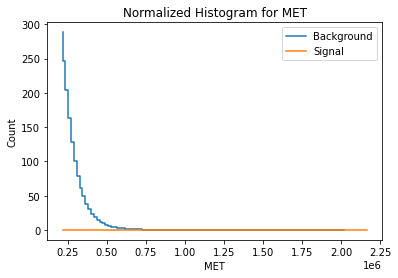

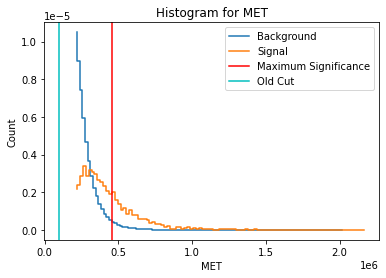

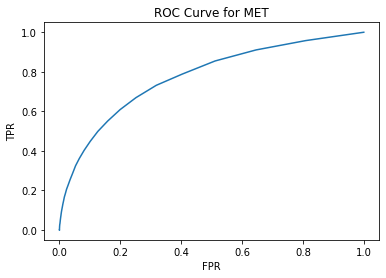

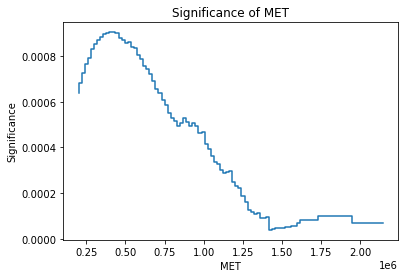

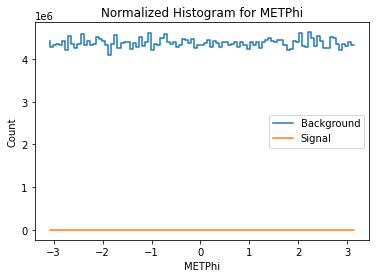

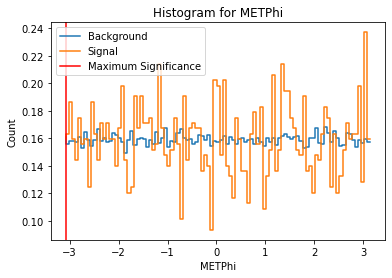

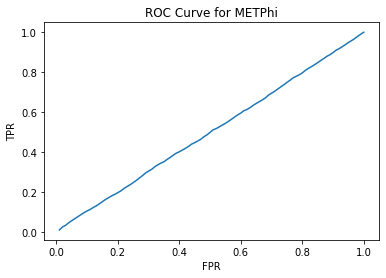

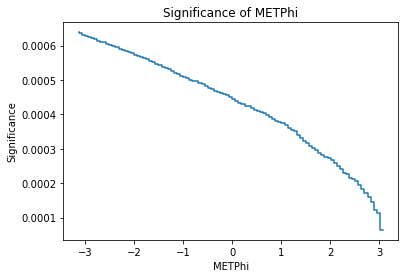

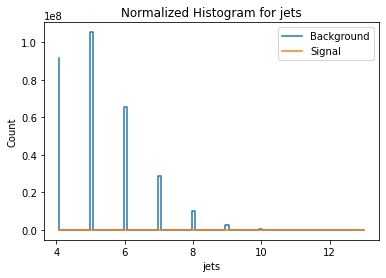

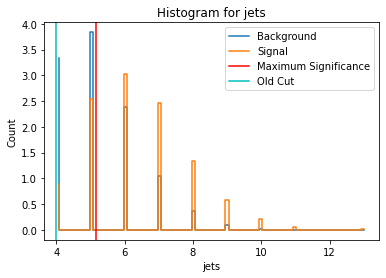

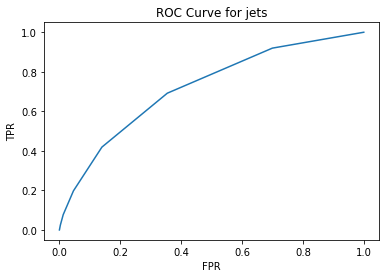

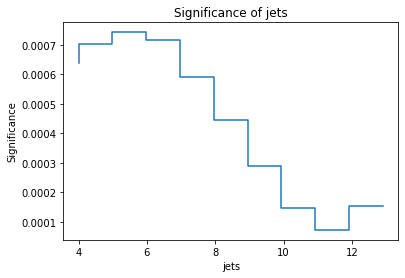

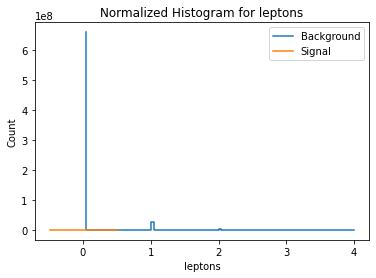

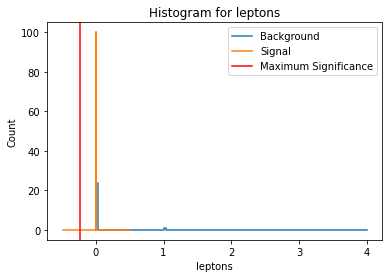

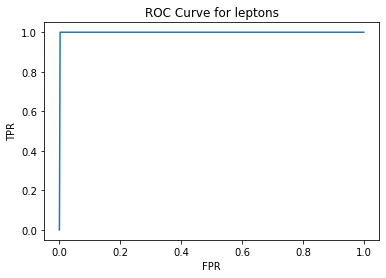

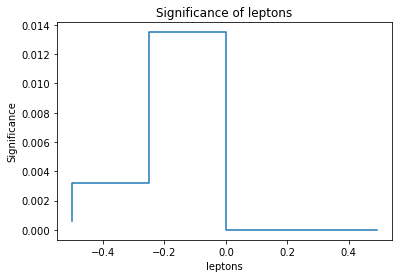

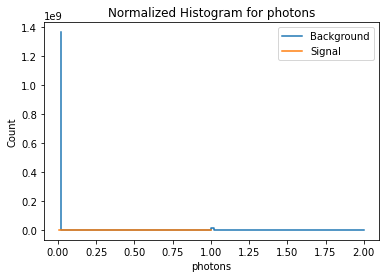

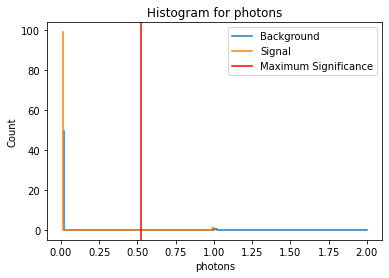

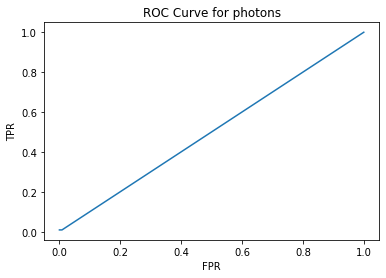

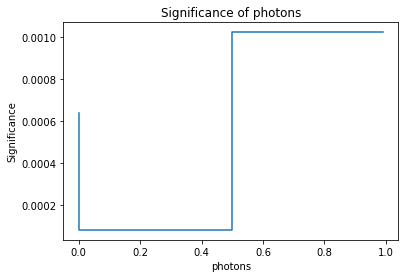

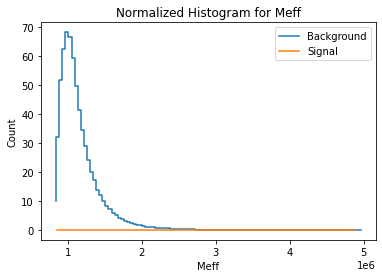

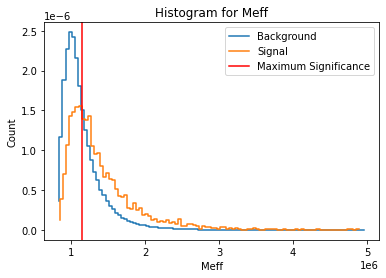

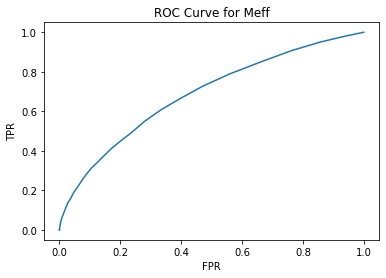

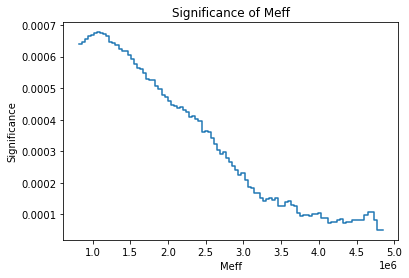

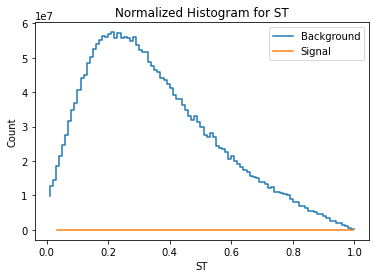

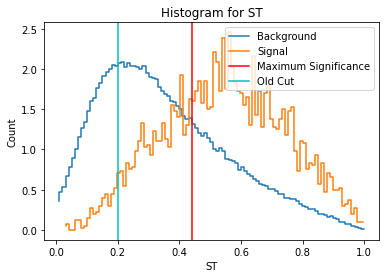

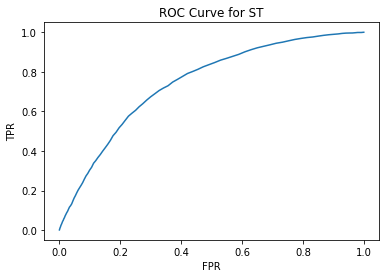

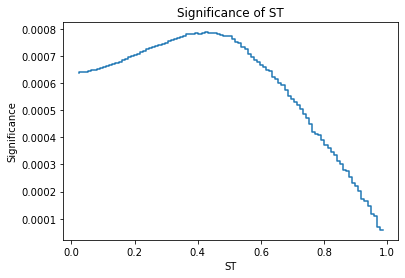

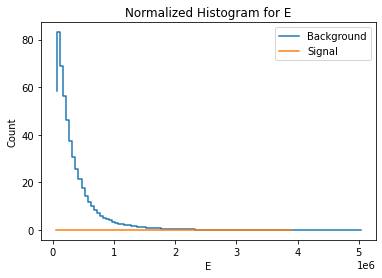

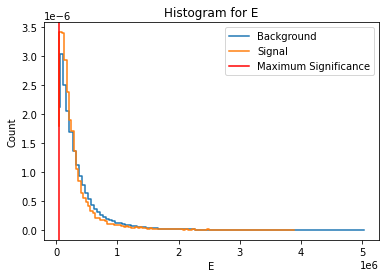

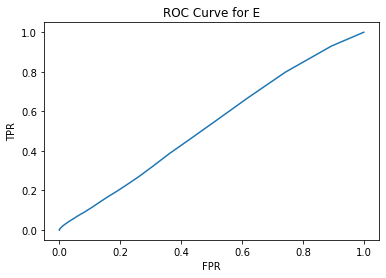

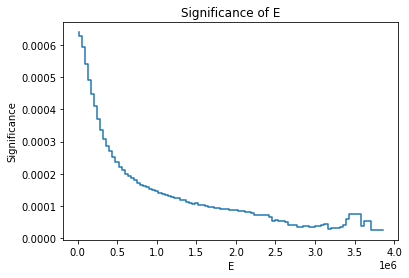

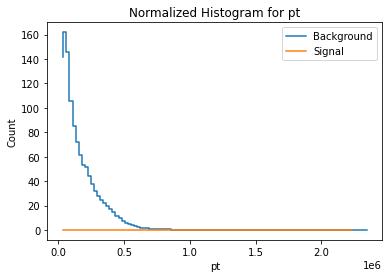

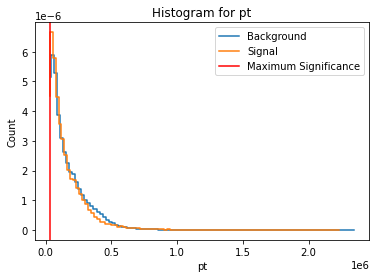

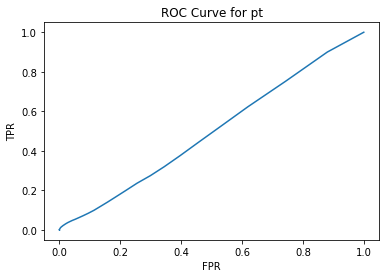

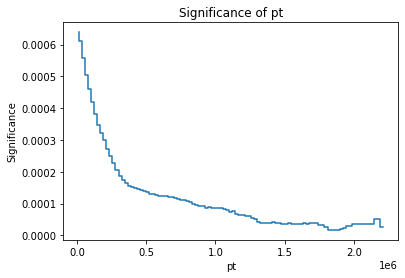

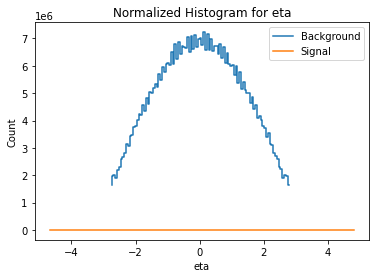

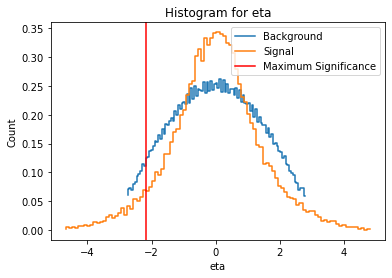

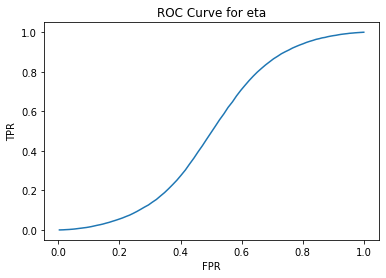

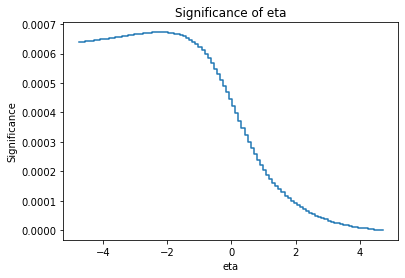

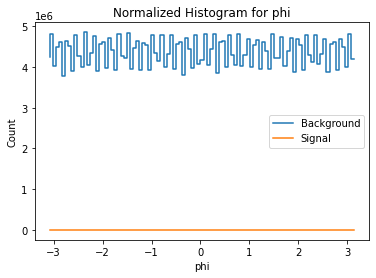

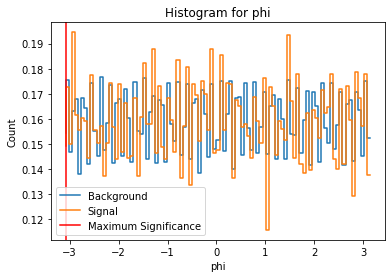

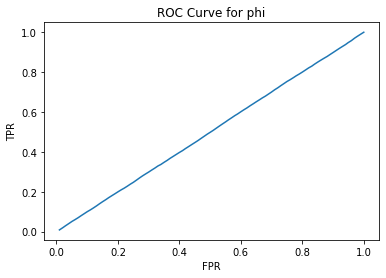

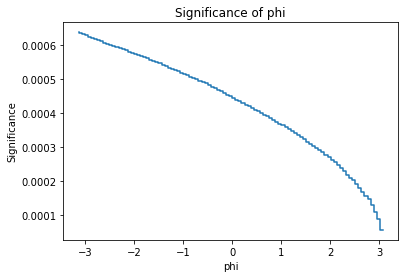

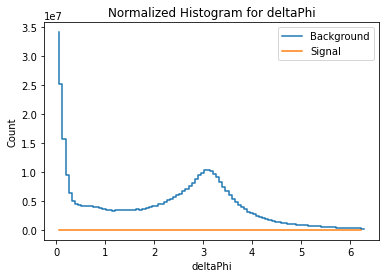

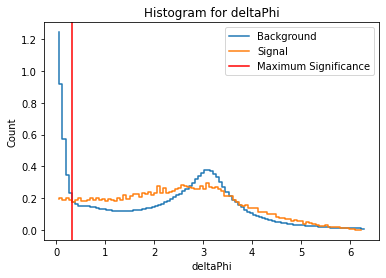

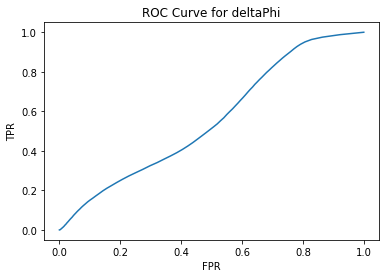

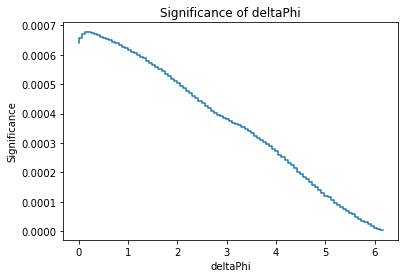

In [55]:
makePlots(data, 100, 1000)

In [56]:
makeCutFlowTable(data, 100, 10000)

Data,Original Maximum Significance,New Max Significance,Original Number of Signal,New Number of Signal,Original Number of Background,New Number of Background,Original Number of Signal Expected,New Number of Signal Expected,Original Number of Background Expected,New Number of Background Expected,Original Signal Efficiency,New Signal Efficiency,Original Background Efficiency,New Background Efficiency
Raw,0.00202039,0.00202039,4096,4096,214185,214185,33.5012,33.5012,2.74949e+08,2.74949e+08,1,1,1,1
Jet Selection,0.00202039,0.00234793,4096,2834,214185,75922,33.5012,23.1793,2.74949e+08,9.74608e+07,1,0.691895,1,0.354469
MET Selection,0.00202039,0.0029468,4096,1328,214185,7135,33.5012,12.0231,2.74949e+08,1.6647e+07,1,0.518701,1,0.170807
Sphericity Selection,0.00229087,0.0033608,3944,878,156887,2045,32.0535,8.15727,1.95773e+08,5.89119e+06,0.956787,0.678464,0.712034,0.353889
Delta Phi Selection,0.00240864,0.00347889,2882,659,20185,376,30.934,7.93093,1.64941e+08,5.19717e+06,0.965072,0.972253,0.842513,0.882194
Effective Mass Selection,0.00289379,0.00347889,1439,654,4709,371,16.9911,7.93093,3.44754e+07,5.19717e+06,0.549271,1,0.209017,1
